#Install Libraries

In [1]:
#NLTK libraries to remove stopwords, for lemmatization and tokenizing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [3]:
from tabulate import tabulate

In [4]:
from wordcloud import WordCloud, STOPWORDS

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [6]:
from scipy import stats

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [8]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [9]:
import gensim
from gensim.models import Word2Vec

#Load Data

In [10]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
#Loading the training set
train_read=pd.read_csv("/content/gdrive/MyDrive/EmoInt/fear/train_fear.txt",delimiter = "\t",names=["Index", "Tweet", "Emotion", "Emotion Intensity"])

In [12]:
#Loading the development set
dev_read=pd.read_csv("/content/gdrive/MyDrive/EmoInt/fear/dev_fear_intensity.txt",delimiter = "\t",names=["Index", "Tweet", "Emotion", "Emotion Intensity"])

In [13]:
#Loading the test set
test_read=pd.read_csv("/content/gdrive/MyDrive/EmoInt/fear/test_fear_intensity.txt",delimiter = "\t",names=["Index", "Tweet", "Emotion", "Emotion Intensity"])

In [14]:
#Display the training data for anger 
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity
0,20000,I feel like I am drowning. #depression #anxiet...,fear,0.979
1,20001,I get so nervous even thinking about talking t...,fear,0.979
2,20002,I lost my blinders .... #panic,fear,0.975
3,20003,I feel like I am drowning. #depression #falur...,fear,0.938
4,20004,This is the scariest American Horror Story out...,fear,0.938


In [15]:
#Display the development data for anger 
dev_read.head()

,Index,Tweet,Emotion,Emotion Intensity
0,21147,I know this is going to be one of those nights...,fear,0.771
1,21148,This is #horrible: Lewis Dunk has begun networ...,fear,0.479
2,21149,"@JeffersonLake speaking of ex cobblers, saw Ri...",fear,0.417
3,21150,@1johndes ball watching &amp; Rojo'd header wa...,fear,0.475
4,21151,"Really.....#Jumanji 2....w/ The Rock, Jack Bla...",fear,0.542


In [16]:
#Display the test data for anger 
test_read.head()

,Index,Tweet,Emotion,Emotion Intensity
0,21257,#Matthew 25; 1-13\nCould somebody shoot a #vid...,fear,0.417
1,21258,@bkero @whispersystems Which really sucks beca...,fear,0.438
2,21259,Be #afraid of the #quiet ones they are the one...,fear,0.542
3,21260,@riinkanei he's a horrible person and now i ga...,fear,0.583
4,21261,What we fear doing most is usually what we mos...,fear,0.292


#Data Analysis

In [17]:
#Length of training set
train_read.shape[0]

1147

In [18]:
#Length of development set
dev_read.shape[0]

110

In [19]:
#Length of test set
test_read.shape[0]

995

In [20]:
#Data type of each column in training set
train_read.dtypes

Index                  int64
Tweet                 object
Emotion               object
Emotion Intensity    float64
dtype: object

In [21]:
#Converting tweet and emotion from object to string type
train_read.astype({'Tweet':'string', 'Emotion':'string'}).dtypes

Index                  int64
Tweet                 string
Emotion               string
Emotion Intensity    float64
dtype: object

In [22]:
#Describe the dataset
train_read.describe()

,Index,Emotion Intensity
count,1147.000000,1147.000000
mean,20573.000000,0.495579
std,331.254686,0.194792
min,20000.000000,0.062000
25%,20286.500000,0.354000
50%,20573.000000,0.479000
75%,20859.500000,0.625000
max,21146.000000,0.979000


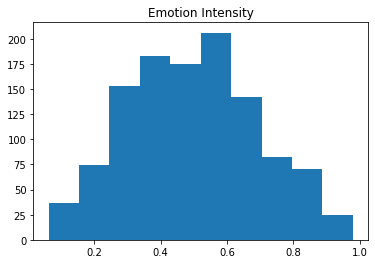

In [23]:
hist = train_read.hist(column='Emotion Intensity',grid=False)

#Text Cleaning

## Converting to Lower Case

In [24]:
train_read['Cleaned Text']=train_read['Tweet'].str.lower()

In [25]:
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity,Cleaned Text
0,20000,I feel like I am drowning. #depression #anxiet...,fear,0.979,i feel like i am drowning. #depression #anxiet...
1,20001,I get so nervous even thinking about talking t...,fear,0.979,i get so nervous even thinking about talking t...
2,20002,I lost my blinders .... #panic,fear,0.975,i lost my blinders .... #panic
3,20003,I feel like I am drowning. #depression #falur...,fear,0.938,i feel like i am drowning. #depression #falur...
4,20004,This is the scariest American Horror Story out...,fear,0.938,this is the scariest american horror story out...


In [26]:
dev_read['Cleaned Text']=dev_read['Tweet'].str.lower()

In [27]:
test_read['Cleaned Text']=test_read['Tweet'].str.lower()

## Removing Numbers

In [28]:
train_read['Tweet'][33]

'Just want Saturday to be over but then again I want to do good #LSAT #nervous'

In [29]:
train_read['Cleaned Text'].replace('\d+', '', regex=True, inplace=True)

In [30]:
train_read['Cleaned Text'][33]

'just want saturday to be over but then again i want to do good #lsat #nervous'

In [31]:
dev_read['Cleaned Text'].replace('\d+', '', regex=True, inplace=True)

In [32]:
test_read['Cleaned Text'].replace('\d+', '', regex=True, inplace=True)

## Removing URLs

In [33]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')

In [34]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')

In [35]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')

## Separating Hashtags

In [36]:
train_read['Tweet'][3]

'I feel like I am drowning. #depression  #falure #worthless'

In [37]:
def separating_hashtags(text):
  return re.findall("#([a-zA-Z0-9_]{1,50})", text)

In [38]:
def removing_hashtags(text):
  return re.sub("#[A-Za-z0-9_]+","", text)

In [39]:
train_read['Hashtags'] = train_read['Tweet'].apply(separating_hashtags)
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(removing_hashtags)

In [40]:
train_read['Cleaned Text'][3]

'i feel like i am drowning.    '

In [41]:
train_read['Hashtags'][3]

['depression', 'falure', 'worthless']

In [42]:
dev_read['Hashtags'] = dev_read['Tweet'].apply(separating_hashtags)
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(removing_hashtags)

In [43]:
test_read['Hashtags'] = test_read['Tweet'].apply(separating_hashtags)
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(removing_hashtags)

## Removing UserHandles




In [44]:
train_read['Tweet'][16]

'anxiety level- 100'

In [45]:
def removeUserHandles(text):
  return re.sub("@[A-Za-z0-9_]+","", text)

In [46]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(removeUserHandles)

In [47]:
train_read['Cleaned Text'][16]

'anxiety level- '

In [48]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(removeUserHandles)

In [49]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(removeUserHandles)

##Removing Special Characters

In [50]:
train_read['Tweet'][27]

'@tchop__StL @YouTube \\nI get sick to my stomach everytime I see this video &amp; for the helicopter crew to make such comments is revolting.'

In [51]:
def remove_specialCharacters(text):
  return re.sub(r"[^\*a-zA-Z0-9]"," ",text)

In [52]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(remove_specialCharacters)

In [53]:
train_read['Cleaned Text'][27]

'   ni get sick to my stomach everytime i see this video  amp  for the helicopter crew to make such comments is revolting '

In [54]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(remove_specialCharacters)

In [55]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(remove_specialCharacters)

## Tokenizing

In [56]:
def tokenize(text):
  return word_tokenize(text)

In [57]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(tokenize)

In [58]:
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity,Cleaned Text,Hashtags
0,20000,I feel like I am drowning. #depression #anxiet...,fear,0.979,"[i, feel, like, i, am, drowning]","[depression, anxiety, falure, worthless]"
1,20001,I get so nervous even thinking about talking t...,fear,0.979,"[i, get, so, nervous, even, thinking, about, t...",[]
2,20002,I lost my blinders .... #panic,fear,0.975,"[i, lost, my, blinders]",[panic]
3,20003,I feel like I am drowning. #depression #falur...,fear,0.938,"[i, feel, like, i, am, drowning]","[depression, falure, worthless]"
4,20004,This is the scariest American Horror Story out...,fear,0.938,"[this, is, the, scariest, american, horror, st...",[frightened]


In [59]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(tokenize)

In [60]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(tokenize)

## Remove Stopwords

In [61]:
stop_words = set(stopwords.words('english'))

In [62]:
def remove_stopwords(word_list):
  return [word for word in word_list if word not in stopwords.words('english')]

In [63]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(remove_stopwords)

In [64]:
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity,Cleaned Text,Hashtags
0,20000,I feel like I am drowning. #depression #anxiet...,fear,0.979,"[feel, like, drowning]","[depression, anxiety, falure, worthless]"
1,20001,I get so nervous even thinking about talking t...,fear,0.979,"[get, nervous, even, thinking, talking, ******...",[]
2,20002,I lost my blinders .... #panic,fear,0.975,"[lost, blinders]",[panic]
3,20003,I feel like I am drowning. #depression #falur...,fear,0.938,"[feel, like, drowning]","[depression, falure, worthless]"
4,20004,This is the scariest American Horror Story out...,fear,0.938,"[scariest, american, horror, story, gon, na, w...",[frightened]


In [65]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(remove_stopwords)

In [66]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(remove_stopwords)

##Lemmatization

In [67]:
lemmatizer = WordNetLemmatizer()

In [68]:
def lemmatize(word_list):
  lemmatized_output = ' '.join([lemmatizer.lemmatize(w, pos = "v") for w in word_list])
  return nltk.word_tokenize(lemmatized_output)

In [69]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(lemmatize)

In [70]:
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity,Cleaned Text,Hashtags
0,20000,I feel like I am drowning. #depression #anxiet...,fear,0.979,"[feel, like, drown]","[depression, anxiety, falure, worthless]"
1,20001,I get so nervous even thinking about talking t...,fear,0.979,"[get, nervous, even, think, talk, ******, wan,...",[]
2,20002,I lost my blinders .... #panic,fear,0.975,"[lose, blinders]",[panic]
3,20003,I feel like I am drowning. #depression #falur...,fear,0.938,"[feel, like, drown]","[depression, falure, worthless]"
4,20004,This is the scariest American Horror Story out...,fear,0.938,"[scariest, american, horror, story, gon, na, w...",[frightened]


In [71]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(lemmatize)

In [72]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(lemmatize)

## Word Cloud

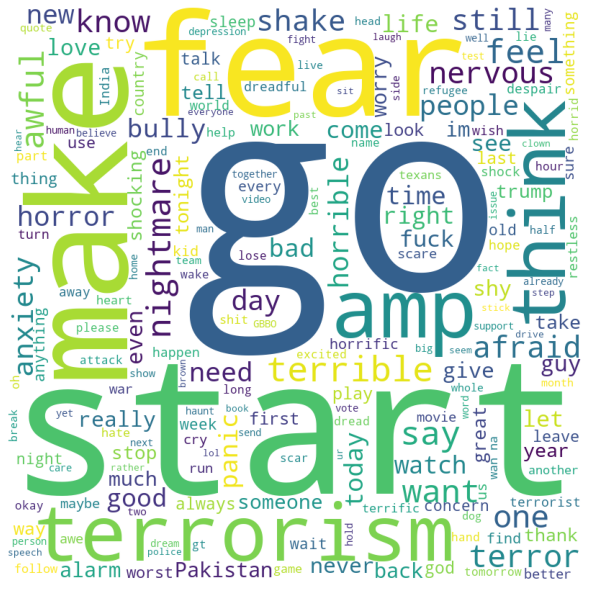

In [73]:
comment_words = ''
for val in train_read['Cleaned Text']:
    comment_words += " ".join(val)+" "

for val in train_read['Hashtags']:
    comment_words += " ".join(val)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [74]:
#Unique words in Train set
len(comment_words)
li = list(comment_words.split(" "))
x=np.array(li)
max_words=len(np.unique(x))

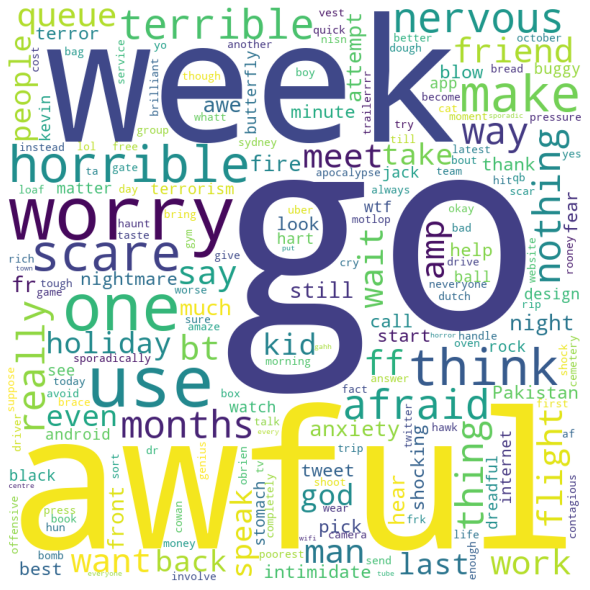

In [75]:
comment_words = ''
for val in dev_read['Cleaned Text']:
    comment_words += " ".join(val)+" "

for val in dev_read['Hashtags']:
    comment_words += " ".join(val)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [76]:
#Unique words in Dev set
len(comment_words)
li = list(comment_words.split(" "))
x=np.array(li)
len(np.unique(x))

565

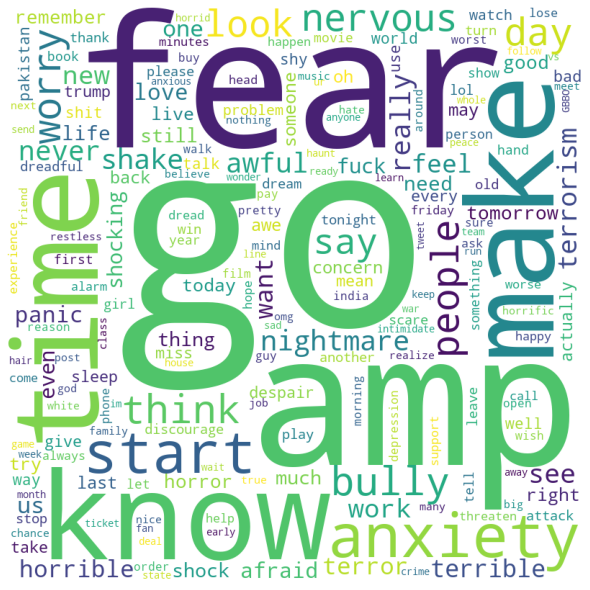

In [77]:
comment_words = ''
for val in test_read['Cleaned Text']:
    comment_words += " ".join(val)+" "

for val in test_read['Hashtags']:
    comment_words += " ".join(val)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [78]:
#Unique words in Test set
len(comment_words)
li = list(comment_words.split(" "))
x=np.array(li)
len(np.unique(x))

2765

# Text Pre-processing

In [79]:
def join_sent(text):  
    str1 = " "
    return str1.join(text)

In [80]:
train_read['Tweet text']=train_read['Cleaned Text']+train_read['Hashtags']

In [81]:
dev_read['Tweet text']=dev_read['Cleaned Text']+dev_read['Hashtags']

In [82]:
test_read['Tweet text']=test_read['Cleaned Text']+test_read['Hashtags']

In [83]:
train_read['Sentences']=train_read['Tweet text'].apply(join_sent)

In [84]:
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity,Cleaned Text,Hashtags,Tweet text,Sentences
0,20000,I feel like I am drowning. #depression #anxiet...,fear,0.979,"[feel, like, drown]","[depression, anxiety, falure, worthless]","[feel, like, drown, depression, anxiety, falur...",feel like drown depression anxiety falure wort...
1,20001,I get so nervous even thinking about talking t...,fear,0.979,"[get, nervous, even, think, talk, ******, wan,...",[],"[get, nervous, even, think, talk, ******, wan,...",get nervous even think talk ****** wan na die
2,20002,I lost my blinders .... #panic,fear,0.975,"[lose, blinders]",[panic],"[lose, blinders, panic]",lose blinders panic
3,20003,I feel like I am drowning. #depression #falur...,fear,0.938,"[feel, like, drown]","[depression, falure, worthless]","[feel, like, drown, depression, falure, worthl...",feel like drown depression falure worthless
4,20004,This is the scariest American Horror Story out...,fear,0.938,"[scariest, american, horror, story, gon, na, w...",[frightened],"[scariest, american, horror, story, gon, na, w...",scariest american horror story gon na watch da...


In [85]:
dev_read['Sentences']=dev_read['Tweet text'].apply(join_sent)

In [86]:
test_read['Sentences']=test_read['Tweet text'].apply(join_sent)

In [87]:
def max_len_sent():
  max=0
  for i in train_read['Tweet text']:
    if len(i)>max:
      max=len(i)
  return max

max_len_train=max_len_sent()
max_len_train

23

In [88]:
def max_len_sent():
  max=0
  for i in dev_read['Tweet text']:
    if len(i)>max:
      max=len(i)
  return max

max_len_dev=max_len_sent()
max_len_dev

18

In [89]:
def max_len_sent():
  max=0
  for i in test_read['Tweet text']:
    if len(i)>max:
      max=len(i)
  return max

max_len_test=max_len_sent()
max_len_test

24

In [90]:
train_read_5 = train_read[train_read['Emotion Intensity'] > 0.5]

In [91]:
dev_read_5 = dev_read[dev_read['Emotion Intensity'] > 0.5]

In [92]:
#test_read_5 = test_read[test_read['Emotion Intensity'] > 0.5]

In [93]:
data_to_list = train_read['Sentences'].values.tolist()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_to_list)
sequences = tokenizer.texts_to_sequences(data_to_list)
train_data = pad_sequences(sequences, maxlen=max_len_train)
print(train_data)

[[   0    0    0 ...   27  807  808]
 [   0    0    0 ...  123   71  422]
 [   0    0    0 ...  137  809   23]
 ...
 [   0    0    0 ... 1685 1686 1687]
 [   0    0    0 ...   50   61   46]
 [   0    0    0 ...  345 1642  152]]


In [94]:
data_to_list = dev_read['Sentences'].values.tolist()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_to_list)
sequences = tokenizer.texts_to_sequences(data_to_list)
dev_data = pad_sequences(sequences, maxlen=max_len_dev)
print(dev_data)

[[  0   0   0 ...  35 255 256]
 [  0   0   0 ... 264   8 265]
 [  0  37 266 ...  69 275  70]
 ...
 [  0   0   0 ... 565  55 566]
 [  0   0   0 ...  33 251  49]
 [  0   0   0 ...  46  33 251]]


In [95]:
data_to_list = test_read['Sentences'].values.tolist()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_to_list)
sequences = tokenizer.texts_to_sequences(data_to_list)
test_data = pad_sequences(sequences, maxlen=max_len_test)
print(test_data)

[[   0    0    0 ...  712   27  511]
 [   0    0    0 ...  120   35  157]
 [   0    0    0 ...   41  715   12]
 ...
 [   0    0    0 ...   17 2713 2714]
 [   0    0    0 ... 1064   20   92]
 [   0    0    0 ...  532 2723 2724]]


In [96]:
y_train = train_read['Emotion Intensity'].to_numpy()
y_train=y_train.reshape(len(train_data),1)

In [97]:
y_dev = dev_read['Emotion Intensity'].to_numpy()
y_dev=y_dev.reshape(len(dev_data),1)

In [98]:
y_test = test_read['Emotion Intensity'].to_numpy()
y_test=y_test.reshape(len(test_data),1)

In [99]:
data_to_list = train_read_5['Sentences'].values.tolist()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_to_list)
sequences = tokenizer.texts_to_sequences(data_to_list)
train_data_5 = pad_sequences(sequences, maxlen=max_len_train)
print(train_data_5)

[[   0    0    0 ...   11  390  391]
 [   0    0    0 ...  190   47  191]
 [   0    0    0 ...   98  817    8]
 ...
 [   0    0    0 ...  233  181   60]
 [   0    0    0 ...   44  816    5]
 [   0    0    0 ...   73  245 1932]]


In [100]:
data_to_list = dev_read_5['Sentences'].values.tolist()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_to_list)
sequences = tokenizer.texts_to_sequences(data_to_list)
dev_data_5 = pad_sequences(sequences, maxlen=max_len_dev)
print(dev_data_5)

[[  0   0   0   0   0   0   0   0   0  87   4   3  88  89  90  91  92  93]
 [  0   0   0   0   0   0   0   9  10  15  16  17  18  19  20  21  22  23]
 [  0   0   0   0   0   0   9  10  15  16  17  18  19  20  21  22  23  11]
 [  0   0   0   0   0   0   0   0   0   0  94  95  24  96  97  98  99 100]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   4  25  26   1  27]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   4  25  26  27]
 [  0   0   0   0   0   0   0   0   0   0   0  28 101 102 103 104 105  29]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 106   5  30 107 108]
 [  0   0   0   0   0   0   0   0 109 110 111 112  12 113  31 114 115 116]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 117 118 119 120  32]
 [  0   0   0   0   0   0  33  34  35   6  36  37   2  38  39  40  41   7]
 [  0   0   0   0   0   0   0  33  34  35   6  36  37   2  38  39  40  41]
 [121 122 123   2 124 125 126 127 128 129 130 131 132 133 134  13 135 136]
 [  0   0   0   0   0 137

In [101]:
#data_to_list = test_read_5['Sentences'].values.tolist()
#tokenizer = Tokenizer(num_words=max_words)
#tokenizer.fit_on_texts(data_to_list)
#sequences = tokenizer.texts_to_sequences(data_to_list)
#test_data_5 = pad_sequences(sequences, maxlen=max_len_test)

In [102]:
y_train_5 = train_read_5['Emotion Intensity'].to_numpy()
y_train_5=y_train_5.reshape(len(train_data_5),1)

In [103]:
y_dev_5 = dev_read_5['Emotion Intensity'].to_numpy()
y_dev_5=y_dev_5.reshape(len(dev_data_5),1)

In [104]:
#y_test_5 = test_read_5['Emotion Intensity'].to_numpy()
#y_test_5=y_test_5.reshape(len(test_data_5),1)

#Generate Embeddings

##Lexicons

In [105]:
#lexicon_dict=pd.read_csv("/content/gdrive/MyDrive/EmoInt/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt",delimiter = "\t",header=None)


In [106]:
#lexicon_dict

In [107]:
#lexiconDf = pd.DataFrame(columns=['Word','anger','fear','joy','sadness'])

In [108]:
#ind=0
#coun=0
#for i in lexicon_dict.index:
#  if ind<len(lexicon_dict):
#    lexiconDf.loc[coun,'Word'] =lexicon_dict.loc[lexicon_dict.index[ind]][0]
#    lexiconDf.loc[coun,'anger']=lexicon_dict.loc[lexicon_dict.index[ind]][2]
#    lexiconDf.loc[coun,'fear']=lexicon_dict.loc[lexicon_dict.index[ind+3]][2]
#    lexiconDf.loc[coun,'joy']=lexicon_dict.loc[lexicon_dict.index[ind+4]][2]
#    lexiconDf.loc[coun,'sadness']=lexicon_dict.loc[lexicon_dict.index[ind+7]][2]
#  else:
#    break
#  ind += 10
#  coun+=1

In [109]:
#lexiconDf

In [110]:
#def lexicon_avg_train():
#  val=[]
#  for i in train_read['Tweet text']:
#    avg=0
#    count=0
#    for j in i:
#      count=count+1
#      qs=lexiconDf[lexiconDf.eq(j).any(1)]
#      if (qs.empty)==False:
#        avg=avg+int(qs['fear'])
#    avg=avg/count
#    val.append(avg)
#  return val

#lexicon_train_set=lexicon_avg_train()

In [111]:
#def lexicon_avg_dev():
#  val=[]
#  for i in dev_read['Tweet text']:
#    avg=0
#    count=0
#    for j in i:
#      count=count+1
#      qs=lexiconDf[lexiconDf.eq(j).any(1)]
#      if (qs.empty)==False:
#        avg=avg+int(qs['fear'])
#    avg=avg/count
#    val.append(avg)
#  return val

#lexicon_dev_set=lexicon_avg_dev()

In [112]:
#def lexicon_avg_test():
#  val=[]
#  for i in test_read['Tweet text']:
#    avg=0
#    count=0
#    for j in i:
#      count=count+1
#      qs=lexiconDf[lexiconDf.eq(j).any(1)]
#      if (qs.empty)==False:
#        avg=avg+int(qs['fear'])
#    avg=avg/count
#    val.append(avg)
#  return val

#lexicon_test_set=lexicon_avg_test()

In [113]:
#textfile = open("/content/gdrive/MyDrive/EmoInt/fear/file1content.txt", "w")
#for element in lexicon_train_set:
#    textfile.write(str(element) + "\n")
#textfile.close()

In [114]:
#textfile = open("/content/gdrive/MyDrive/EmoInt/fear/file2content.txt", "w")
#for element in lexicon_dev_set:
#    textfile.write(str(element) + "\n")
#textfile.close()

In [115]:
#textfile = open("/content/gdrive/MyDrive/EmoInt/fear/file3content.txt", "w")
#for element in lexicon_test_set:
#    textfile.write(str(element) + "\n")
#textfile.close()

In [116]:
with open('/content/gdrive/MyDrive/EmoInt/fear/file1content.txt') as f:
    lexicon_train_set = f.read().splitlines()

for i in range(0, len(lexicon_train_set)):
    lexicon_train_set[i] = float(lexicon_train_set[i])

In [117]:
with open('/content/gdrive/MyDrive/EmoInt/fear/file2content.txt') as f:
    lexicon_dev_set = f.read().splitlines()

for i in range(0, len(lexicon_dev_set)):
    lexicon_dev_set[i] = float(lexicon_dev_set[i])

In [118]:
with open('/content/gdrive/MyDrive/EmoInt/fear/file3content.txt') as f:
    lexicon_test_set = f.read().splitlines()

for i in range(0, len(lexicon_test_set)):
    lexicon_test_set[i] = float(lexicon_test_set[i])

In [119]:
Xarr1 = np.array(lexicon_train_set)
Xarr1=Xarr1.reshape(len(Xarr1),1)
yarr1 = train_read['Emotion Intensity'].to_numpy()
yarr1=yarr1.reshape(len(Xarr1),1)
lexicon_train=np.hstack((Xarr1,yarr1))

In [120]:
Xarr2 = np.array(lexicon_dev_set)
Xarr2=Xarr2.reshape(len(Xarr2),1)
yarr2 = dev_read['Emotion Intensity'].to_numpy()
yarr2=yarr2.reshape(len(Xarr2),1)
lexicon_dev=np.hstack((Xarr2,yarr2))

In [121]:
Xarr3 = np.array(lexicon_test_set)
Xarr3=Xarr3.reshape(len(Xarr3),1)
yarr3 = test_read['Emotion Intensity'].to_numpy()
yarr3=yarr3.reshape(len(Xarr3),1)
lexicon_test=np.hstack((Xarr3,yarr3))

In [122]:
filter = lexicon_train[:,1]>0.5
lexicon_train_5=lexicon_train[filter]

In [123]:
filter = lexicon_dev[:,1]>0.5
lexicon_dev_5=lexicon_dev[filter]

In [124]:
#filter = lexicon_test[:,1]>0.5
#lexicon_test_5=lexicon_test[filter]

## Word2Vec

In [125]:
from gensim.models import KeyedVectors
filename = '/content/gdrive/MyDrive/EmoInt/GoogleNews-vectors-negative300.bin.gz'
wordmodel = KeyedVectors.load_word2vec_format(filename, binary=True)

In [126]:
pretrained_weights = wordmodel.wv.syn0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [127]:
vocab_size, emdedding_size = pretrained_weights.shape

#Evaluation Metrics

In [128]:
def evaluate(pred_scores,gold_scores,pred_scores_range_05_1,gold_scores_range_05_1):
  pears_corr=stats.pearsonr(pred_scores,gold_scores)[0]
  spear_corr=stats.spearmanr(pred_scores,gold_scores)[0]
  pears_corr_range_05_1=stats.pearsonr(pred_scores_range_05_1,gold_scores_range_05_1)[0]                                    
  spear_corr_range_05_1=stats.spearmanr(pred_scores_range_05_1,gold_scores_range_05_1)[0]       
  return [pears_corr,spear_corr,pears_corr_range_05_1,spear_corr_range_05_1]

#Models

##Statistical Model

### SVM Regression 

In [136]:
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(lexicon_train[:,0].reshape(-1, 1), lexicon_train[:,1])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

In [137]:
y_pred=regr.predict(lexicon_dev[:,1].reshape(-1, 1))

In [138]:
y_pred_5=regr.predict(lexicon_dev_5[:,1].reshape(-1, 1))

In [139]:
[pears_corr1,spear_corr1,pears_corr_range_05_11,spear_corr_range_05_11]=evaluate(y_pred,lexicon_dev[:,1],y_pred_5,lexicon_dev_5[:,1])
print('Pearsons correlation for gold score:'+str(pears_corr1))
print('Spearmans correlation for gold score:'+str(spear_corr1))
print('Pearsons correlation for gold score for gold score greater than 0.5:'+str(pears_corr_range_05_11))
print('Spearmans correlation for gold score for gold score greater than 0.5:'+str(spear_corr_range_05_11))

Pearsons correlation for gold score:0.3187902041162276
Spearmans correlation for gold score:0.20634605402721673
Pearsons correlation for gold score for gold score greater than 0.5:0.29051997288262404
Spearmans correlation for gold score for gold score greater than 0.5:0.2712501091989167


### Linear Regression

In [140]:
reg = LinearRegression().fit(lexicon_train[:,0].reshape(-1, 1), lexicon_train[:,1])

In [141]:
reg.score(lexicon_train[:,0].reshape(-1, 1), lexicon_train[:,1])

0.09373677653088763

In [142]:
m=reg.coef_
m

array([0.39104982])

In [143]:
b=reg.intercept_
b

0.4372924896815129

In [144]:
y_pred=reg.predict(lexicon_dev[:,1].reshape(-1, 1))

In [145]:
y_pred_5=reg.predict(lexicon_dev_5[:,1].reshape(-1, 1))

In [146]:
[pears_corr2,spear_corr2,pears_corr_range_05_12,spear_corr_range_05_12]=evaluate(y_pred,lexicon_dev[:,1],y_pred_5,lexicon_dev_5[:,1])
print('Pearsons correlation for gold score:'+str(pears_corr2))
print('Spearmans correlation for gold score:'+str(spear_corr2))
print('Pearsons correlation for gold score for gold score greater than 0.5:'+str(pears_corr_range_05_12))
print('Spearmans correlation for gold score for gold score greater than 0.5:'+str(spear_corr_range_05_12))

Pearsons correlation for gold score:1.0
Spearmans correlation for gold score:1.0
Pearsons correlation for gold score for gold score greater than 0.5:0.9999999999999999
Spearmans correlation for gold score for gold score greater than 0.5:0.9999999999999999


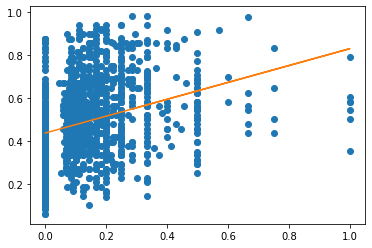

In [147]:
plt.plot(lexicon_train[:,0], lexicon_train[:,1], 'o')
plt.plot(lexicon_train[:,0], m*lexicon_train[:,0] + b)
plt.show()

## Deep Learning Models

### LSTM

In [129]:
model1 = Sequential()
model1.add(layers.Embedding(input_dim=vocab_size, output_dim=emdedding_size,weights=[pretrained_weights]))
model1.add(layers.LSTM(15,dropout=0.5)) #Our LSTM layer
model1.add(layers.Dense(3,activation='relu'))
model1.compile(optimizer='adam',loss='mse')

In [130]:
history = model1.fit(train_data, y_train, epochs=5,validation_data=(dev_data,y_dev))

Epoch 1/5
36/36 [==============================] - 309s 9s/step - loss: 0.0850 - val_loss: 0.0381
Epoch 2/5
36/36 [==============================] - 295s 8s/step - loss: 0.0352 - val_loss: 0.0398
Epoch 3/5
36/36 [==============================] - 309s 9s/step - loss: 0.0244 - val_loss: 0.0404
Epoch 4/5
36/36 [==============================] - 324s 9s/step - loss: 0.0186 - val_loss: 0.0440
Epoch 5/5
36/36 [==============================] - 297s 8s/step - loss: 0.0143 - val_loss: 0.0499


In [ ]:
model1.save("/content/gdrive/MyDrive/EmoInt/anger/lstm_model")

In [ ]:
model1 = keras.models.load_model('/content/gdrive/MyDrive/EmoInt/anger/lstm_model')

In [131]:
y_pred = model1.predict(dev_data)

In [132]:
y_pred_5 = model1.predict(dev_data_5)

In [133]:
y_pred=y_pred[:,0].reshape(dev_data.shape[0],1)
y_pred_5=y_pred_5[:,0].reshape(dev_data_5.shape[0],1)
y_pred = np.squeeze(y_pred)
y_dev = np.squeeze(y_dev)
y_pred_5 = np.squeeze(y_pred_5)
y_dev_5 = np.squeeze(y_dev_5)

In [134]:
[pears_corr3,spear_corr3,pears_corr_range_05_13,spear_corr_range_05_13]=evaluate(y_pred,y_dev,y_pred_5,y_dev_5)
print('Pearsons correlation for gold score:'+str(pears_corr3))
print('Spearmans correlation for gold score:'+str(spear_corr3))
print('Pearsons correlation for gold score for gold score greater than 0.5:'+str(pears_corr_range_05_13))
print('Spearmans correlation for gold score for gold score greater than 0.5:'+str(spear_corr_range_05_13))

Pearsons correlation for gold score:0.03764144477956715
Spearmans correlation for gold score:0.017240682306722148
Pearsons correlation for gold score for gold score greater than 0.5:0.015145320777924024
Spearmans correlation for gold score for gold score greater than 0.5:0.15030329173457047


### Bidirectional LSTM

In [129]:
model2 = Sequential()
model2.add(layers.Embedding(input_dim=vocab_size, output_dim=emdedding_size,weights=[pretrained_weights]))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='relu'))
model2.compile(optimizer='adam',loss='mse',)

In [130]:
history2 = model2.fit(train_data, y_train, epochs=5,validation_data=(dev_data,y_dev))

Epoch 1/5
36/36 [==============================] - 283s 8s/step - loss: 0.0863 - val_loss: 0.0398
Epoch 2/5
36/36 [==============================] - 329s 9s/step - loss: 0.0383 - val_loss: 0.0377
Epoch 3/5
36/36 [==============================] - 340s 9s/step - loss: 0.0306 - val_loss: 0.0394
Epoch 4/5
36/36 [==============================] - 313s 9s/step - loss: 0.0237 - val_loss: 0.0433
Epoch 5/5
36/36 [==============================] - 339s 9s/step - loss: 0.0187 - val_loss: 0.0450


In [ ]:
model2.save("/content/gdrive/MyDrive/EmoInt/anger/bidirectional_lstm_model")

In [ ]:
model2 = keras.models.load_model('/content/gdrive/MyDrive/EmoInt/anger/bidirectional_lstm_model')

In [131]:
y_pred = model2.predict(dev_data)

In [132]:
y_pred_5 = model2.predict(dev_data_5)

In [133]:
y_pred=y_pred[:,0].reshape(dev_data.shape[0],1)
y_pred_5=y_pred_5[:,0].reshape(dev_data_5.shape[0],1)
y_pred = np.squeeze(y_pred)
y_dev = np.squeeze(y_dev)
y_pred_5 = np.squeeze(y_pred_5)
y_dev_5 = np.squeeze(y_dev_5)

In [134]:
[pears_corr4,spear_corr4,pears_corr_range_05_14,spear_corr_range_05_14]=evaluate(y_pred,y_dev,y_pred_5,y_dev_5)
print('Pearsons correlation for gold score:'+str(pears_corr4))
print('Spearmans correlation for gold score:'+str(spear_corr4))
print('Pearsons correlation for gold score for gold score greater than 0.5:'+str(pears_corr_range_05_14))
print('Spearmans correlation for gold score for gold score greater than 0.5:'+str(spear_corr_range_05_14))

Pearsons correlation for gold score:-0.014526567193507239
Spearmans correlation for gold score:-0.03583463638006299
Pearsons correlation for gold score for gold score greater than 0.5:0.052746260531215464
Spearmans correlation for gold score for gold score greater than 0.5:0.18528391853988838


###1-D Conv Net

In [129]:
model3 = Sequential()
model3.add(layers.Embedding(input_dim=vocab_size, output_dim=emdedding_size,weights=[pretrained_weights]))
model3.add(layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=2))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(1, activation='relu'))
model3.compile(optimizer='adam',loss='mse')

In [130]:
history3 = model3.fit(train_data, y_train, epochs=5,validation_data=(dev_data,y_dev))

Epoch 1/5
36/36 [==============================] - 286s 8s/step - loss: 0.0541 - val_loss: 0.0419
Epoch 2/5
36/36 [==============================] - 276s 8s/step - loss: 0.0270 - val_loss: 0.0522
Epoch 3/5
36/36 [==============================] - 263s 7s/step - loss: 0.0200 - val_loss: 0.0484
Epoch 4/5
36/36 [==============================] - 333s 9s/step - loss: 0.0123 - val_loss: 0.0468
Epoch 5/5
36/36 [==============================] - 293s 8s/step - loss: 0.0104 - val_loss: 0.0441


In [ ]:
model3.save("/content/gdrive/MyDrive/EmoInt/anger/1ConvNet_model")

In [ ]:
model3 = keras.models.load_model('/content/gdrive/MyDrive/EmoInt/anger/1ConvNet_model')

In [131]:
y_pred = model3.predict(dev_data)

In [132]:
y_pred_5 = model3.predict(dev_data_5)

In [133]:
y_pred=y_pred[:,0].reshape(dev_data.shape[0],1)
y_pred_5=y_pred_5[:,0].reshape(dev_data_5.shape[0],1)
y_pred = np.squeeze(y_pred)
y_dev = np.squeeze(y_dev)
y_pred_5 = np.squeeze(y_pred_5)
y_dev_5 = np.squeeze(y_dev_5)

In [134]:
[pears_corr5,spear_corr5,pears_corr_range_05_15,spear_corr_range_05_15]=evaluate(y_pred,y_dev,y_pred_5,y_dev_5)
print('Pearsons correlation for gold score:'+str(pears_corr5))
print('Spearmans correlation for gold score:'+str(spear_corr5))
print('Pearsons correlation for gold score for gold score greater than 0.5:'+str(pears_corr_range_05_15))
print('Spearmans correlation for gold score for gold score greater than 0.5:'+str(spear_corr_range_05_15))

Pearsons correlation for gold score:0.11580220791951187
Spearmans correlation for gold score:0.10153598064940053
Pearsons correlation for gold score for gold score greater than 0.5:-0.08798741236881746
Spearmans correlation for gold score for gold score greater than 0.5:-0.050246486383698545


#Results

In [ ]:
d = [ ["SVM Regression with Lexicons", pears_corr1, spear_corr1, pears_corr_range_05_11,spear_corr_range_05_11],
     ["Linear Regression with Lexicons", pears_corr2, spear_corr2, pears_corr_range_05_12,spear_corr_range_05_12],
     ["Word2Vec + LSTM", pears_corr3, spear_corr3, pears_corr_range_05_13,spear_corr_range_05_13]
     ["Word2Vec + Bidirectional LSTM", pears_corr4, spear_corr4, pears_corr_range_05_14,spear_corr_range_05_14]
     ["Word2vec + 1-D Convolutional Network", pears_corr5, spear_corr5, pears_corr_range_05_15,spear_corr_range_05_15]]

print(tabulate(d, headers=["Models", "Pearsons correlation", "Spearsons correlation",'Pearsons correlation with gold score>0.5','Spearsons correlation with gold score>0.5']))